In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
import nibabel as nib
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle


### load patient info ###

info = pd.read_csv('S:\\Usyd\\Project\\Data\\info2.csv',index_col = 0)

labelsDict = {}
ijkDict = {}
proscenDict = {}
patientcase = {}
for i in range (1,len(info)+1):
    labels = info.get_value(i,'label')
    ijk = info.get_value(i, 'ijk')
    patient_id = info.get_value(i, 'pt_id')
    proscen = info.get_value(i, 'pros_cen')
#    print(patient_id)
#    print(labels)
#    print('Tumour location:', ijk)
#    print('Prostate center location:', proscen)
    patientcase[i] = patient_id
    labelsDict[i] = labels
    ijkDict[i] = ijk
    proscenDict[i] = proscen
    
labels = []
for i in labelsDict:
    labels += [labelsDict[i]]
    
case = []
for i in patientcase:
    case += [patientcase[i]]
    
ijk = []
for i in ijkDict:
    ijk += [ijkDict[i]]

proscen = []
for i in proscenDict:
    proscen += [proscenDict[i]]
    
print('All the relevant info has been loaded')

D:\Anaconda_3\lib\site-packages\dipy\viz\__init__.py:22: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


All the relevant info has been loaded


D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [2]:
### get the x,y,z coordinates of the tumour and prostate center ###
### check for the distance in x,y,z between prostate center and tumour ###
x= [None] * len (ijk)
y= [None] * len (ijk)
z= [None] * len (ijk)
X= [None] * len (ijk)
Y= [None] * len (ijk)
Z= [None] * len (ijk)
for i in range(0, len(ijk)):
    a = ijk[i].split()
    x[i] = a[0]          # tumour x-coordinate
    y[i] = a[1]          # tumour y-coordinate
    z[i] = a[2]          # tumour z-coordinate
for i in range(0, len(ijk)):
    b = proscen[i].split()
    X[i] = b[0]          # prostate center x-coordinate
    Y[i] = b[1]          # prostate center y-coordinate
    Z[i] = b[2]          # prostate center z-coordinate
    

### convert string into int ###    
x = [int(i) for i in x]
y = [int(i) for i in y]
z = [int(i) for i in z] 
X = [int(i) for i in X] 
Y = [int(i) for i in Y] 
Z = [int(i) for i in Z] 

### find the maximum distance between prostate center and tumour ###
xx = np.array(x)
yy = np.array(y)
zz = np.array(z)
XX = np.array(X)
YY = np.array(Y)
ZZ = np.array(Z)
xdiff = abs(xx.astype(np.int) - XX.astype(np.int))
ydiff = abs(yy.astype(np.int) - YY.astype(np.int))
zdiff = abs(zz.astype(np.int) - ZZ.astype(np.int))
print('The maximum distance between the prostate center and tumour is:', max(xdiff), 'in x-direction and', max(ydiff), 'in y-direction.')

The maximum distance between the prostate center and tumour is: 65 in x-direction and 73 in y-direction.


In [3]:
### Load input images ###
### Image Re-sample so that they all have the same dimension of t2w,adc and ktrans ###

stack=[]
for i in case[0:5]:
    directory = "S:\\Usyd\\Project\\Data\\mri\\" + i
    print(directory)
    s = os.listdir(directory)
    t2w = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[2])
    adc = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[0])
    ktrans = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[1])
    
    static = t2w.get_data()
    static_grid2world = t2w.affine
    moving = adc.get_data()
    moving_grid2world = adc.affine
    moving2 = ktrans.get_data()
    moving2_grid2world = ktrans.affine
    identity = np.eye(4)
    affine_map = AffineMap(identity, static.shape, static_grid2world, moving.shape, moving_grid2world)
    resample1 = affine_map.transform(moving)
    affine_map2 = AffineMap(identity, static.shape, static_grid2world, moving2.shape, moving2_grid2world)
    resample2 = affine_map2.transform(moving2)
    output = np.stack([static.transpose(2,1,0),resample1.transpose (2,1,0), resample2.transpose(2,1,0)], axis = -1)
    print(output.shape)
    patient = output
    stack += [patient]

S:\Usyd\Project\Data\mri\pt_0000
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0001
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0002
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0002
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0003
(21, 384, 384, 3)


In [4]:
    
### Crop the images into size 224 x 224 ###
cstack=[]
for j in range (len(stack)):
    cpatient = stack[j][Z[j],Y[j]-112:Y[j]+112,X[j]-112:X[j]+112,:]      # Note that coordinates order: [slice,y,x,z]
    cstack += [cpatient]

Finding  1
pt_0000
Tumour location: 167 224 9
Prostate center: 191 212 9
The finding is:  True


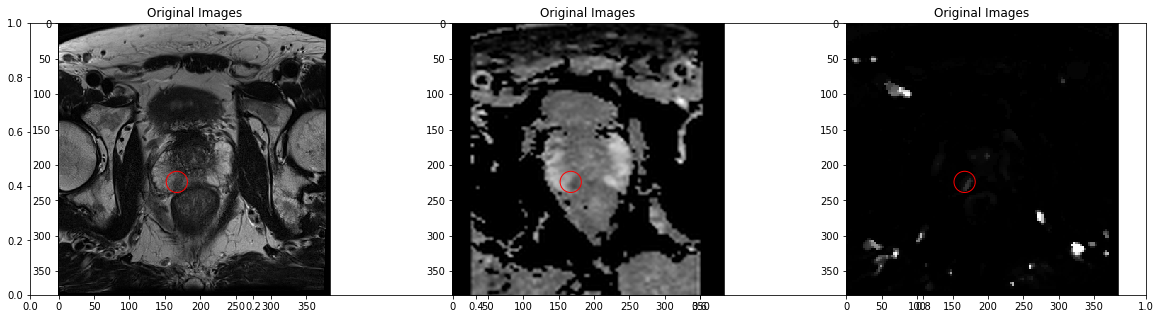

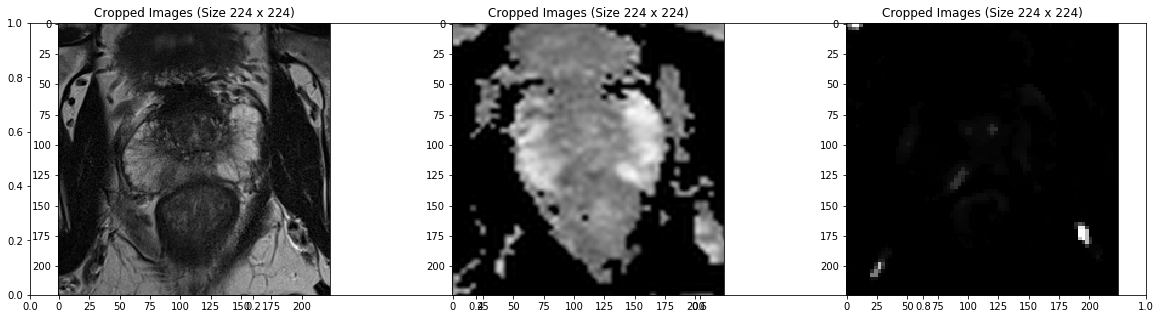

Finding  2
pt_0001
Tumour location: 157 186 10
Prostate center: 190 198 10
The finding is:  False


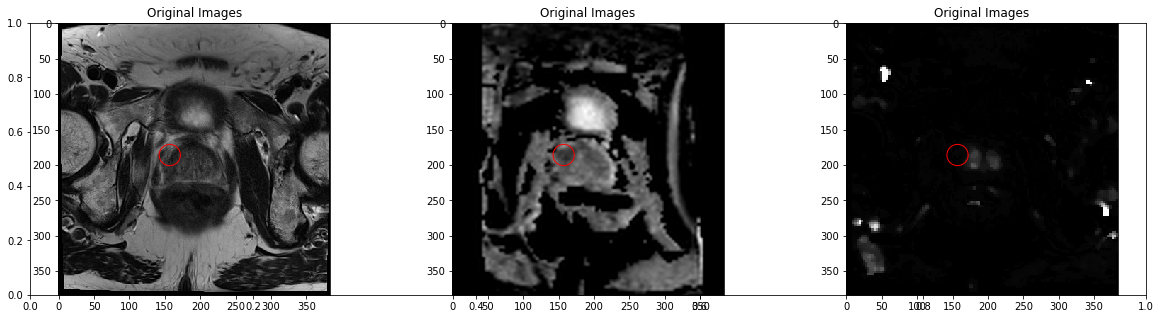

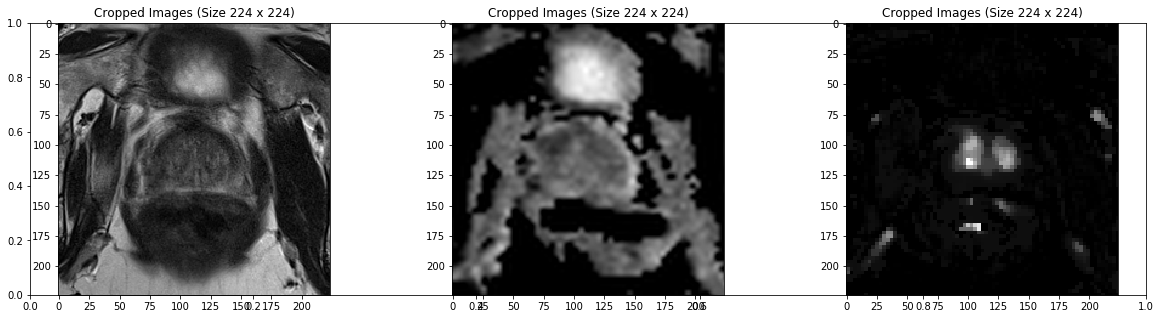

Finding  3
pt_0002
Tumour location: 203 216 10
Prostate center: 187 207 10
The finding is:  False


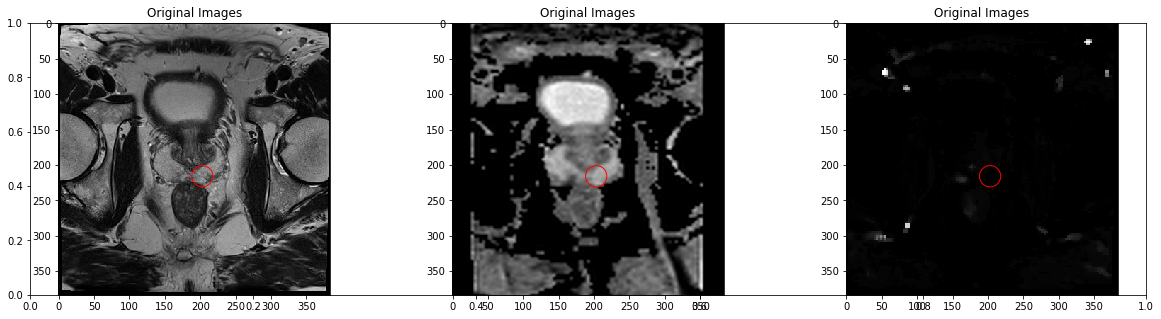

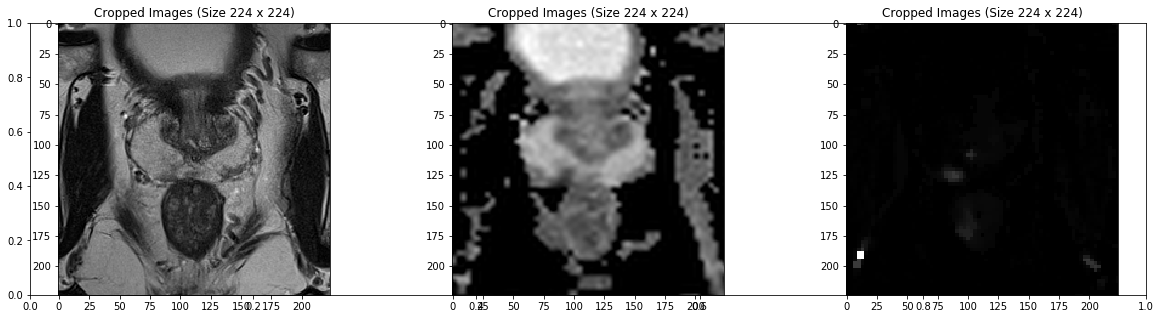

Finding  4
pt_0002
Tumour location: 154 217 12
Prostate center: 188 207 12
The finding is:  True


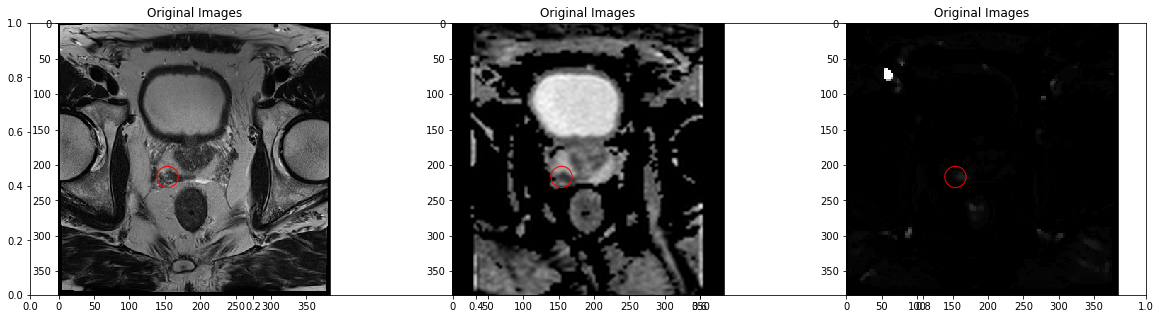

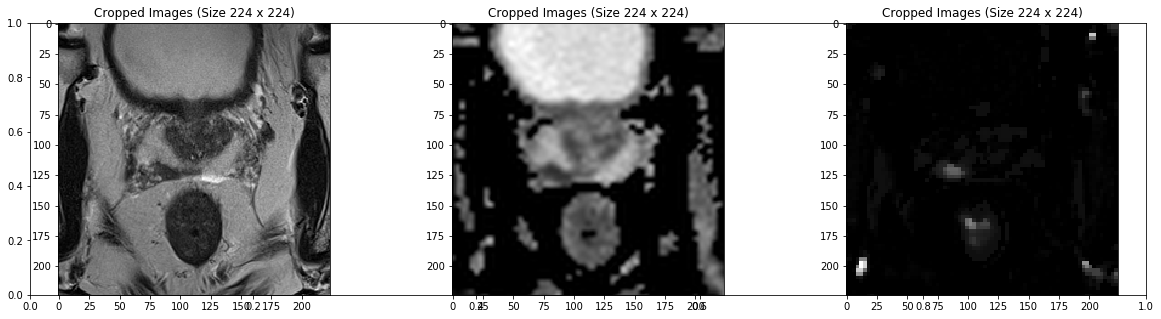

Finding  5
pt_0003
Tumour location: 240 205 12
Prostate center: 197 192 12
The finding is:  False


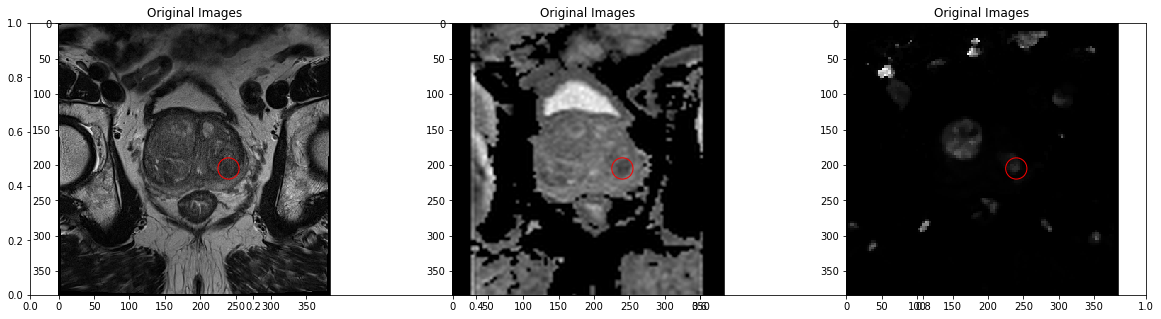

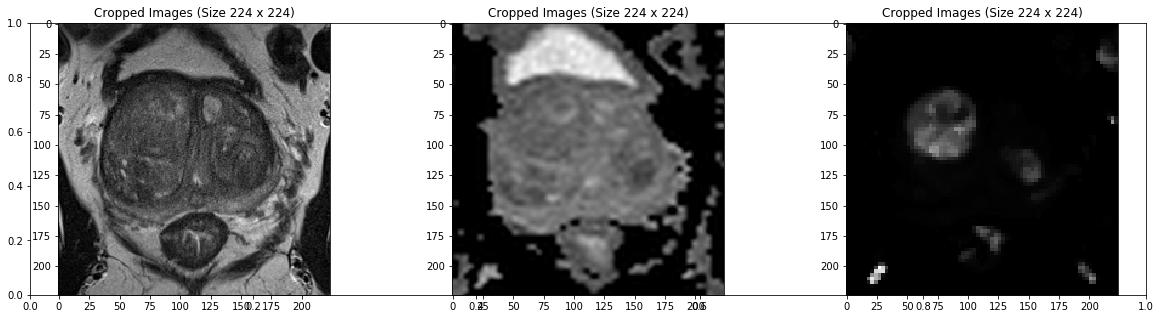

In [5]:
### Display the images of the first 20 patients ###

for j in range (len(stack)):
    img = stack[j]
    img2 = cstack[j]
    print ('Finding ', str(j+1))
    print (case[j])
    print ('Tumour location:', ijk[j])
    print ('Prostate center:', proscen[j])
    print ('The finding is: ', labels[j])
    fig, axes = plt.subplots(figsize=(20,5))
    for i in range (0,3):
        image = img[z[j],:,:,i]
        ax1 = fig.add_subplot(1, 3, i+1)
        plt.imshow(image,cmap ='gray')
        circ = Circle((x[j],y[j]),15, fill=False, color='red')
        ax1.add_patch(circ)
        plt.title('Original Images')
    plt.show()
    fig, axes = plt.subplots(figsize=(20,5))
    for i in range (0,3):
        image2 = img2[:,:,i]
        ax1 = fig.add_subplot(1, 3, i+1)
        plt.imshow(image2,cmap ='gray')
        plt.title('Cropped Images (Size 224 x 224)')
    plt.show()

In [8]:
import pickle
filename1 = 'test'
outfile = open(filename1,'wb')
pickle.dump(np.array(cstack) ,outfile)
pickle.dump(labels ,outfile)
pickle.dump(ijk ,outfile)
pickle.dump(case, outfile)
outfile.close()

In [9]:
infile = open('test','rb')
Images = pickle.load(infile)
Labels = pickle.load(infile)
Coordinates = pickle.load(infile)
Patientid = pickle.load(infile)
infile.close()

In [10]:
Images.shape

(20, 224, 224, 3)

In [5]:
len(stack)

100

In [6]:
stack1 = stack

In [8]:
len(stack1)

100